# ej 3
En el campus encontrará el archivo “datos_para_clustering.mat” que contiene una
matriz de datos de 500 mediciones de una variable de 100 dimensiones.
a) Utilice una red de Kohonen para reducir la dimensionalidad de los datos.
b) Verifique la presencia de clusters, e indique cuantos puede visualizar, haciendo uso
de la matriz U.

## Matriz U para clustering con Kohonen

Vamos a realizar clustering utilizando un mapa autoorganizado (SOM) de Kohonen.  
El SOM consiste en una grilla 2D de neuronas, donde cada neurona posee un vector de pesos de dimensión 100, correspondiente a las 100 características de los datos de entrada.

Sobre la matriz de pesos del SOM calcularemos la **matriz U**.

---

## ¿Qué es la matriz U?

La **matriz U** (Unified Distance Matrix) es una representación visual que permite analizar la topología y calidad del ordenamiento del SOM.

La matriz U muestra:

- Zonas donde las neuronas son similares entre sí (distancias pequeñas) → posibles clústeres.
- Zonas donde hay cambios bruscos entre neuronas (distancias grandes) → fronteras entre clústeres.

---

## Definición formal

Sea un mapa SOM 2D con neuronas indexadas por $(i,j)$, cada una con su vector de pesos:

$$
\mathbf{w}_{i,j} \in \mathbb{R}^{100}
$$

La matriz U asigna a cada neurona el **promedio de distancias** hacia sus neuronas vecinas:

$$
U(i,j) = \frac{1}{|\mathcal{N}_{i,j}|}
\sum_{(k,l)\in \mathcal{N}_{i,j}}
\left\| \mathbf{w}_{i,j} - \mathbf{w}_{k,l} \right\|
$$

donde $\mathcal{N}_{i,j}$ es el conjunto de neuronas vecinas.  
Normalmente se usa:

- Vecindad de Von Neumann (4 vecinos)
- Vecindad de Moore (8 vecinos)

---

## Cálculo paso a paso

1. **Identificar vecinos** de cada neurona $(i,j)$ dentro de la grilla 2D.

2. **Calcular la distancia euclídea** entre el vector de pesos de la neurona y el de cada vecino:

$$
d_{(i,j),(k,l)} = \left\| \mathbf{w}_{i,j} - \mathbf{w}_{k,l} \right\|
$$

3. **Promediar todas las distancias**:

$$
U(i,j) = 
\frac{1}{|\mathcal{N}_{i,j}|}
\sum_{(k,l)\in\mathcal{N}_{i,j}}
d_{(i,j),(k,l)}
$$

4. Repetir el cálculo para todas las neuronas del mapa, generando una matriz 2D del mismo tamaño que el SOM.

---

## Interpretación

- **Valores bajos de $U(i,j)$** → zonas de neuronas similares → pertenecen al mismo clúster.  
- **Valores altos de $U(i,j)$** → transiciones bruscas → fronteras entre clústeres.

En un heatmap:

- **Regiones oscuras** → clústeres compactos  
- **Regiones claras** → límites entre clústeres

---


In [75]:
from scipy.io import loadmat
import numpy as np

ruta = r"C:\Users\ignac\Documents\GitHub\Redes-neuronales\tp3\datos_para_clustering.mat"
mat = loadmat(ruta)

data = mat['datos']  # reemplaza 'datos' con el nombre correcto de la variable que contiene los datos

data = np.array(data)

data.shape


(500, 100)

In [ ]:

class red_kohonen:
    def __init__(self, n_neuronas_x=10, n_neuronas_y=10,
                 tasa_aprendizaje_inicial=0.1, n_iteraciones=100):
        """Red kohonen 2D con vecindad gaussiana 2D."""

        self.n_neuronas_x = n_neuronas_x
        self.n_neuronas_y = n_neuronas_y
        self.tasa_aprendizaje_inicial = tasa_aprendizaje_inicial
        self.n_iteraciones = n_iteraciones

        self.matriz_neuronas = None

        # Precalcular coordenadas de la grilla
        self.grid_x, self.grid_y = np.meshgrid(
            np.arange(n_neuronas_x),
            np.arange(n_neuronas_y),
            indexing='ij'
        )

    def initialize_neurons(self, data):
        """
        Inicializa los pesos de las neuronas con ruido pequeño
        alrededor de muestras aleatorias del dataset.
        """
        n_x, n_y = self.n_neuronas_x, self.n_neuronas_y
        n_features = data.shape[1]

        self.matriz_neuronas = np.zeros((n_x, n_y, n_features))

        # inicialización aleatoria basada en datos
        idx = np.random.choice(data.shape[0], size=n_x * n_y, replace=True)
        base = data[idx].reshape(n_x, n_y, n_features)

        ruido = 0.01 * np.random.randn(n_x, n_y, n_features)

        self.matriz_neuronas = base + ruido


    def entrenar(self, data, varianza_vecindad=3.0):
        """
        Entrena el SOM 2D auténtico, usando vecindad gaussiana 2D.
        """
        # inicializar neuronas con tamaño correcto
        self.initialize_neurons(data)

        n_x, n_y, n_features = self.matriz_neuronas.shape
        n_muestras = data.shape[0]

        for iteracion in range(self.n_iteraciones):

            tasa = self.tasa_aprendizaje_inicial * (1 - iteracion / self.n_iteraciones)
            sigma = varianza_vecindad * (1 - iteracion / self.n_iteraciones)

            # barajar datos
            indices = np.random.permutation(n_muestras)

            for i in indices:
                muestra = data[i]

                # --- 1) BMU ---
                # distancias (n_x × n_y)
                dist = np.linalg.norm(self.matriz_neuronas - muestra, axis=2)
                bmu = np.unravel_index(np.argmin(dist), dist.shape) # encontramos el indice de la neurona más cercana a la muestra
                # luego con unravel vas de un indice plano a uno 2D, porque veniamos de varias dimensiones y le hicimos el índice a una matriz 2D
                bx, by = bmu

                # --- 2) Vecindad Gaussiana 2D ---
                dx = self.grid_x - bx # la grilla entera, en X e Y ajustada por la posición de la BMU (best matching unit, la neurona victoriosa)
                dy = self.grid_y - by
                # esto ya te da toads las distancias cuadradas de cada neurona a la BMU

                dist2 = dx**2 + dy**2 # la distancia euclidea al cuadrado
                h = np.exp(-dist2 / (2 * sigma**2))  # (n_x × n_y)
                # esto hace la aprte gaussiana de la vecindad

                # --- 3) Actualización vectorizada ---
                # reshaping para broadcasting
                h_expand = h[..., np.newaxis]  # (n_x × n_y × 1) - esto es para vectorizar las operaciones, le agrega un eje más

                self.matriz_neuronas += tasa * h_expand * (muestra - self.matriz_neuronas)


In [107]:
# ahora entrenamos la red con los datos cargados
kohonen = red_kohonen(n_neuronas_x=40, n_neuronas_y=40, tasa_aprendizaje_inicial=0.5, n_iteraciones=300)
kohonen.entrenar(data, varianza_vecindad=4.0)

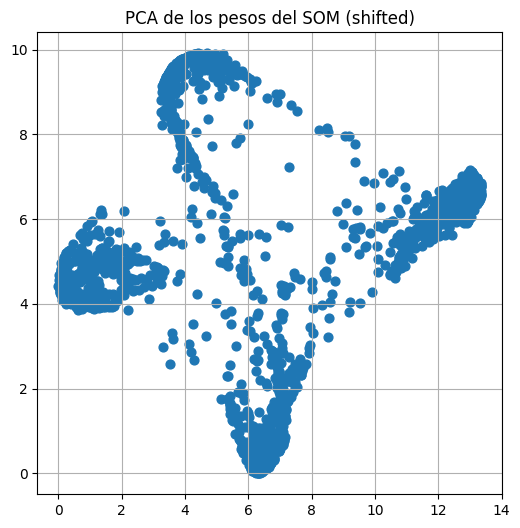

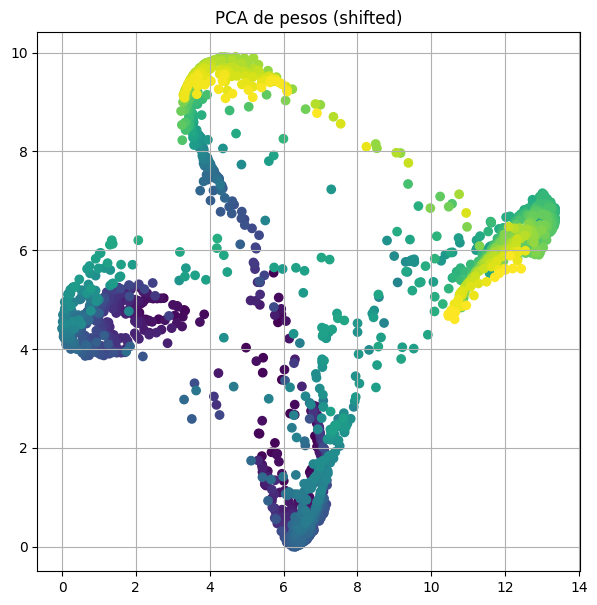

In [108]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Extraer dimensiones reales
D = kohonen.matriz_neuronas.shape[2]

# Aplanar correctamente
W = kohonen.matriz_neuronas.reshape(-1, D)

# PCA
pca = PCA(n_components=2)
W_2D = pca.fit_transform(W)
W_2D_shift = W_2D - W_2D.min(axis=0)

# Colores correctos
colors = np.linspace(0, 1, W.shape[0])

# Scatter básico
plt.figure(figsize=(6,6))
plt.scatter(W_2D_shift[:,0], W_2D_shift[:,1], s=40)
plt.title("PCA de los pesos del SOM (shifted)")
plt.grid(True)

# Scatter coloreado
plt.figure(figsize=(7,7))
plt.scatter(W_2D_shift[:,0], W_2D_shift[:,1], c=colors, cmap='viridis')
plt.title("PCA de pesos (shifted)")
plt.grid(True)

plt.show()

# color de neurona segun indice ineal


In [109]:
from sklearn.decomposition import KernelPCA
import plotly.graph_objects as go

M, N = kohonen.matriz_neuronas.shape[0], kohonen.matriz_neuronas.shape[1]
D = kohonen.matriz_neuronas.shape[2]

# Aplanamos pesos
W = kohonen.matriz_neuronas.reshape(M*N, D)

# --- Kernel PCA NO LINEAL ---
kpca = KernelPCA(
    n_components=3,
    kernel='rbf',          # kernel gaussiano
    gamma=1.0 / D,         # valor típico que anda bien (puede ajustarse)
    fit_inverse_transform=False
)

W_3D = kpca.fit_transform(W)

# Shift para arrancar en 0
W_3D_shift = W_3D - W_3D.min(axis=0)

# Colores por índice
colors = np.linspace(0, 1, M*N)

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=W_3D_shift[:,0],
    y=W_3D_shift[:,1],
    z=W_3D_shift[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=colors,
        colorscale='Viridis',
        opacity=0.9
    )
))

fig.update_layout(
    title="Kernel PCA 3D (RBF) de los pesos del SOM",
    scene=dict(
        xaxis_title='KPCA1',
        yaxis_title='KPCA2',
        zaxis_title='KPCA3'
    ),
    width=800,
    height=800
)

fig.show()


In [110]:
class U_matrix:
    def __init__(self):
        self.u_matrix = None


    def calcular_u_matrix(self,matriz_neuronas):
        """
        Calcula la U-matrix de la red de Kohonen.
        """
        self.u_matrix = np.zeros(matriz_neuronas.shape[:2], dtype=np.float32)


        # vamos a iterar por cada neurona dentro de la grilla y calcular la distancia promedio a sus vecinos
        for i in range(matriz_neuronas.shape[0]):
            for j in range(matriz_neuronas.shape[1]):
                vecinos = []
                
                # vecino arriba
                if i > 0:
                    vecinos.append(matriz_neuronas[i-1, j])
                # vecino abajo
                if i < matriz_neuronas.shape[0] - 1:
                    vecinos.append(matriz_neuronas[i+1, j])
                # vecino izquierda
                if j > 0:
                    vecinos.append(matriz_neuronas[i, j-1])
                # vecino derecha
                if j < matriz_neuronas.shape[1] - 1:
                    vecinos.append(matriz_neuronas[i, j+1])
                
                # calcular la distancia promedio a los vecinos
                distancias = [np.linalg.norm(matriz_neuronas[i, j] - vecino) for vecino in vecinos]
                self.u_matrix[i, j] = np.mean(distancias)



In [111]:
matriz_U = U_matrix()
matriz_U.calcular_u_matrix(kohonen.matriz_neuronas)


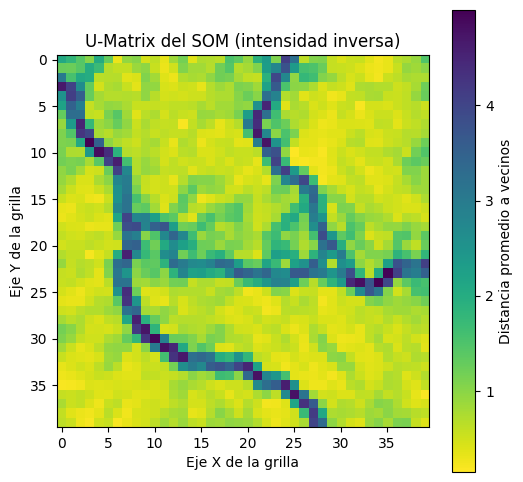

In [112]:
plt.figure(figsize=(6,6))
plt.imshow(matriz_U.u_matrix, cmap='viridis_r', interpolation='nearest')
plt.title("U-Matrix del SOM (intensidad inversa)")
plt.colorbar(label="Distancia promedio a vecinos")
plt.xlabel("Eje X de la grilla")
plt.ylabel("Eje Y de la grilla")
plt.show()


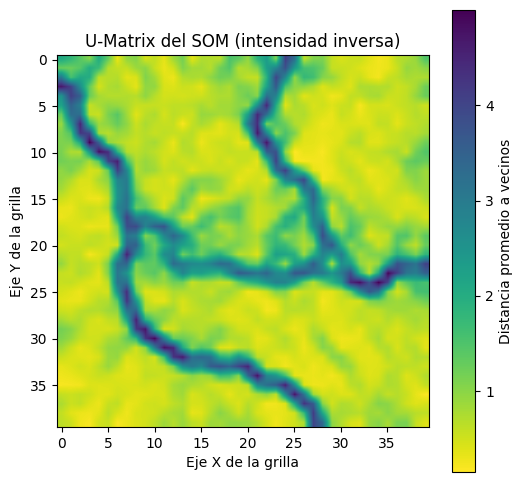

In [113]:
plt.figure(figsize=(6,6))
plt.imshow(matriz_U.u_matrix, cmap='viridis_r', interpolation='bilinear')
plt.title("U-Matrix del SOM (intensidad inversa)")
plt.colorbar(label="Distancia promedio a vecinos")
plt.xlabel("Eje X de la grilla")
plt.ylabel("Eje Y de la grilla")
plt.show()


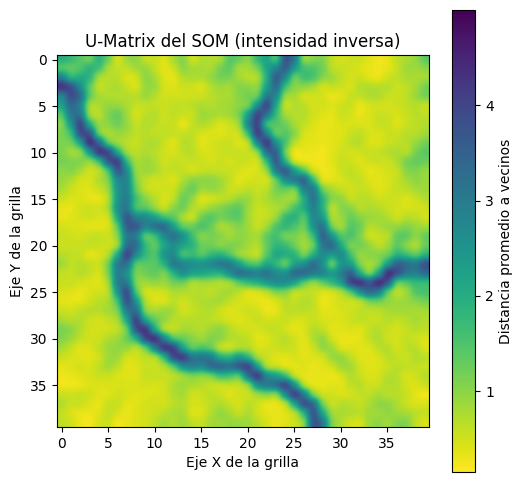

In [114]:
plt.figure(figsize=(6,6))
plt.imshow(matriz_U.u_matrix, cmap='viridis_r', interpolation='gaussian')
plt.title("U-Matrix del SOM (intensidad inversa)")
plt.colorbar(label="Distancia promedio a vecinos")
plt.xlabel("Eje X de la grilla")
plt.ylabel("Eje Y de la grilla")
plt.show()


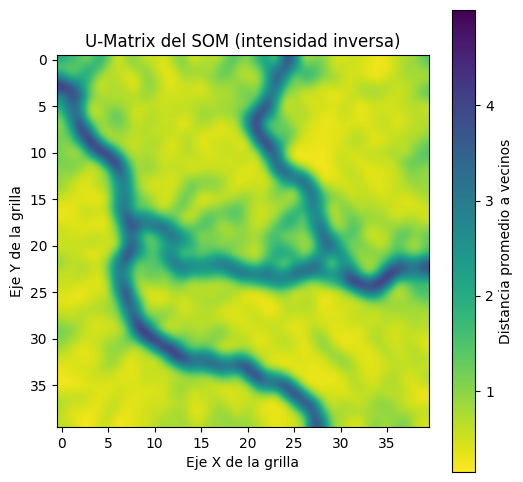

In [115]:
plt.figure(figsize=(6,6))
plt.imshow(matriz_U.u_matrix, cmap='viridis_r', interpolation='bicubic')
plt.title("U-Matrix del SOM (intensidad inversa)")
plt.colorbar(label="Distancia promedio a vecinos")
plt.xlabel("Eje X de la grilla")
plt.ylabel("Eje Y de la grilla")
plt.show()


aumentar la # de neuronas aumenta la resolución de la matriz U